In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [18]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [19]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1]),
                  'path': img_path}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='C:\\Users\somea\\PycharmProjects\\pythonProject\\Images-processed',
                              txt_COVID='COVID/trainCT_COVID.txt',
                              txt_NonCOVID='NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='C:\\Users\somea\\PycharmProjects\\pythonProject\\Images-processed',
                              txt_COVID='COVID/valCT_COVID.txt',
                              txt_NonCOVID='NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='C:\\Users\somea\\PycharmProjects\\pythonProject\\Images-processed',
                              txt_COVID='COVID/testCT_COVID.txt',
                              txt_NonCOVID='NonCOVID/testCT_NonCOVID.txt',
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


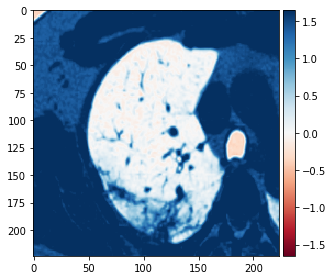

In [20]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [21]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [22]:
#val process is defined here

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [23]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
            # for i in range(len(pred)):
            #     if pred.squeeze()[i] == target.squeeze()[i]:
            #         print(pred.squeeze()[i])
            #         print(batch_samples['path'][i])

    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [24]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""

import torchvision.models as models
model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('model_backup/Dense169.pt')
# pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
pretrained_net = torch.load('model_backup/medical_transfer/OurModel.pt')


model.load_state_dict(pretrained_net)

modelname = 'Dense169_ssl_luna_moco'

In [25]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 3000
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



In [26]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)


# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.25151736e-03 9.99987364e-01 3.04576606e-01 9.74242091e-02
 1.20523581e-02 5.15823765e-03 2.01133707e-06 9.99852538e-01
 8.09089482e-01 9.54986811e-01 9.99787390e-01 9.78038073e-01
 1.02242069e-07 9.99072909e-01 9.99148369e-01 9.98968482e-01
 0.00000000e+00 1.31682515e-01 6.51574850e-01 4.08704758e-01
 1.82528719e-01 1.42607722e-03 4.04712418e-03 2.56059945e-01
 7

3000 EPOCHES PREDTRAINED MODEL

TP= 83 TN= 90 FN= 22 FP= 8
TP+FP 173
precision 0.9120879120879121
recall 0.7904761904761904
F1 0.8469387755102041
acc 0.8522167487684729
AUC 0.9402332361516035

1000 EPOCHES OUR TRAINED MODEL

TP= 92 TN= 48 FN= 13 FP= 50
TP+FP 142
precision 0.647887323943662
recall 0.8761904761904762
F1 0.7449392712550608
acc 0.6896551724137931
AUC 0.82555879494655